## Логистическая регрессия (Logistic Regression) [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

Метод бинарной классификации, который распространим на многоклассовую классификацию путем представления задачи принадлежности к одному классу относительно остальных, суть которого заключючается в построении разделяющей гиперплоскости n-мерного пространства (где n-число предикторов).

Не будем тратить время на демонстрацию того, что в данном случае MSE не лучшая функция потерь, а сразу перейдем к оптимальному вариату используя метод максимального правдоподобия. Функция правдоподобия выглядит следующим образом:

$$ \prod_{i-1}^l (p_{x_i}^{[y_i=+1]} * (1 - p_{x_i})^{[y_i=-1]}) \rightarrow max \tag 1$$

$p_{x_i}$ - вероятность принадлежности к классу "+1"

$[y_i=+1]$ - случай когда целевая переменная на данном наборе входных признаков равна +1

$[y_i=-1]$ - случай когда целевая переменная на данном наборе входных признаков равна -1

Соответственно значение представленной функции мы хотим максимизировать, поскольку оно тем больше чем ближе значение вероятности к единице при прогнозировании принадлежности к классу "+1", и к нулю при прогнозировании принадлежности к классу "-1".

Начнем преобразования: возьмем логарифм (поскольку это не изменит минимум только форму распределения) чтобы перейти от произведений с сумме и знак "-" чтобы перейти к минизации функции, получим логистическую функцию потерь L(y,p):

$$ L(y,p) = - \sum_{i=1}^l ([y_i=+1]\log(p_{x_i}) + [y_i=-1]\log(1 - p_{x_i})) \rightarrow min \tag 2$$

Покажем графически логистическую функцию потерь.

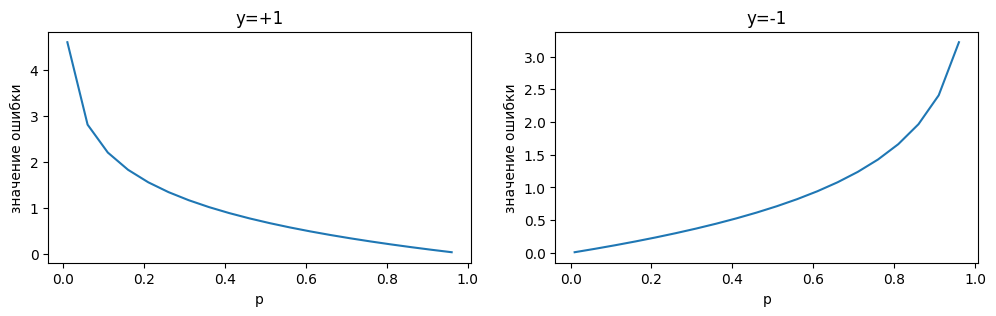

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

p = np.array(np.round(np.arange(0.01, 1, 0.05), 2))
L1 = -np.log(p)
L_1 = -np.log(1-p)

plt.figure(figsize=(12, 3))
plt.subplot (1, 2, 1)
plt.plot(p, L1)
plt.xlabel('p')
plt.ylabel('значение ошибки')
plt.title('y=+1')
plt.subplot (1, 2, 2)
plt.plot(p, L_1)
plt.ylabel('значение ошибки')
plt.xlabel('p')
plt.title('y=-1')
plt.show()

Продолжим преобразование (2) и следующим шагом мы хотим представить вероятность $p_{x_i}$ как результат работы модели, поскольку наша модель линейная, ее выходом является скалярное произведение вектора весов на вектор предикторов $<w, X>$. Однако, результат указанного скалярного произведения представляет собой величину в диапазоне от $-\infty$ до $+\infty$, а наша задача привести к значению от -1 до +1. В этих целях применим к результату скалярного произведения функцию сигмоиду ($\sigma(x) = \frac{1}{1 + \exp(-x)}$), соответственно получим $p_{x_i} = \sigma(\langle w, X\rangle) = \frac{1}{1 + \exp(-\langle w, X\rangle)}$ Подставив полученное выражение $p_{x_i}$ в формулу 2 получим:

$$ L(y, w, X) = - \sum_{i=1}^l ([y_i=+1]\log(\frac{1}{1 + \exp(-\langle w,X\rangle)}) + [y_i=-1]\log(1 - \frac{1}{1 + \exp(-\langle w,X\rangle)})) \tag 3$$

Продолжим преобразования и воспользовавшись свойством логарифма $\log(\frac{x}{y}) = -\log(\frac{y}{x})$ преобразуем первый элемент суммы:

$$\log(\frac{1}{1 + \exp(-\langle w,X\rangle)}) = -\log(1 + \exp(-\langle w,X\rangle)) \tag 4$$

Со вторым элементом суммы придется повозиться чуть подольше и начнем с того что приведем к общему знаменателю и проведем вычитание

$$\log(1 - \frac{1}{1 + \exp(-\langle w,X\rangle)}) = \log(\frac{1 + \exp(-\langle w,X\rangle)}{1 + \exp(-\langle w,X\rangle)} - \frac{1}{1 + \exp(-\langle w,X\rangle)}) = \log(\frac{\exp(-\langle w,X\rangle)}{1 + \exp(-\langle w,X\rangle)})$$

Теперь числитель и знаментатель поделим на числитель и с учетом того что $\frac{1}{\exp(-x)}=\exp(x)$ получим:

$$\log(\frac{\frac{\exp(-\langle w,X\rangle)}{\exp(-\langle w,X\rangle)}}{\frac{1 + \exp(-\langle w,X\rangle)}{\exp(-\langle w,X\rangle)}}) =  \log(\frac{1}{\frac{1}{\exp(-\langle w,X\rangle)} + \frac{\exp(-\langle w,X\rangle)}{\exp(-\langle w,X\rangle)}}) = \log(\frac{1}{\exp(\langle w,X\rangle) + 1}) = -\log(1 + \exp(\langle w,X\rangle)) \tag 5$$

После полученных преобразований результаты формул (4) и (5) подставим в изначальное уравнение (и с учетом минуса за скобками получим):

$$ L(y, w, X) = \sum_{i=1}^l ([y_i=+1]\log({1 + \exp(-\langle w,X\rangle)}) + [y_i=-1]\log(1 + \exp(\langle w,X\rangle))) \tag 6$$

Теперь заметим, что левое слагаемое отличается от правого только знаком после скалярного произведения, а в силу того что индикатор класса обозначает принадлежность класса к "1" или "-1" уравнение можно записать в следующем виде

$$ L(y, w, X) = \sum_{i=1}^l \log(1 + \exp(-y_i \langle w, x_i\rangle)) \tag 7$$

Собственно (7) и есть логистическая функция потерь без учета регуляризации. В качестве регуляризации линейных моделей мы накладываем ограничение на размер весов, l2 регуляризация сумма квадратов весов, а l1 сумма абсолютных значений весов. Воспользуемся l1 регуляризацией, добавим коэффициет "C" перед суммой в формуле (7) влияющий на степень регуляризации и отнормируем значение функции на количество записей в обучающем датасете:

$$ L(y, w, X) = \frac{C}{l}*\sum_{i=1}^l \log(1 + \exp(-y_i \langle w, x_i\rangle)) + \sum_{j=1}^n|w_j|\tag 8$$

***Важно***: в регуляризатор не входит свободный член $w_0$

Далее для минизации используем метод градиентного спуска, для чего найдем частные производные (указывающие в сторону возрастания функции) и будем двигаться в другую сторону (в сторону антиградиента).

Найдем частные производные (8) по w

$$\frac{\partial L(y, w, X)}{\partial w} = - \frac{C}{l}*\sum_{i=1}^l(\frac{y_i*x_{i}*\exp(-y_i*\langle w, x_i\rangle)}{1 + \exp(-y_i*\langle w, x_i\rangle)}) + sign(w) \tag9$$

Антиградиент $\nabla$ соответственно равен

$$\nabla = \frac{C}{l}*\sum_{i=1}^l(\frac{y_i*x_{i}*\exp(-y_i*\langle w, x_i\rangle)}{1 + \exp(-y_i*\langle w, x_i\rangle)}) - sign(w) \tag{10}$$

где результат функции sign равняется "-1" при отрицательном значении $w$, "+1" при положительном значении $w$ и "0" при $w=0$.

Тут считаю необходимым вставку про дифференцирование, конечно можно это продифференцировать руками используя таблицу производных, но если вы сомневаетесь в своих силах, напрочь забыли математику, а восстановление навыка решили пока отложить, это еще не повод отказываться от этого процесса и не пробовать самому. 

Могу предложить два пути решения этой проблемы: 
1) Сайт [wolframalpha](https://www.wolframalpha.com/), пример использования данного ресурса для решения приведенной задачи можно глянуть по [ссылке](https://www.wolframalpha.com/input?i=differentiation+ln%281+%2B+exp%28-y*x*w%29%29) p.s. прикольно что форма представления у вольфрама несколько другая, чтобы формулу (9) привести к такому виду необходимо числитель и знаменатель поделить на $\exp(-y_i*x_{ji}*w_j)$ (похожей историей мы уже занимались выше и с точки зрения вычислений мне этот вариант нравится больше) и историю с регуляризацией лучше дифференцировать отдельно поскольку в противном случае wolfram проводит не нужные нам преобразования, но [результат](https://www.wolframalpha.com/input?i=differentiation+abs%28w%29) не учитывает возможность деления на ноль в отличии от библиотеки sympy.
2) Используя библиотеку [sympy](https://docs.sympy.org/latest/index.html) (пример кода ниже).

In [22]:
import sympy as sp
#инициализируем переменные
x_ = sp.Symbol('x', real=True)
y_ = sp.Symbol('y', real=True)
w_ = sp.Symbol('w', real=True)

#создадим функцию потерь
L = sp.log(1 + sp.exp(-y_*x_*w_)) + sp.Abs(w_)
#отобразим созданную функцию
print('Логистическая функция потерь')
display(L)
#продифференцируем и результат выведим на экран
print('Производная функции потерь по w')
sp.diff(L, w_)

Логистическая функция потерь


log(1 + exp(-w*x*y)) + Abs(w)

Производная функции потерь по w


-x*y*exp(-w*x*y)/(1 + exp(-w*x*y)) + sign(w)

P.S. Идея sign функции мне нравится поскольку мы обходим ситуацию деления на 0.

Итоговая формула антиградиента, которую будем реализовывать

$$\nabla = \frac{C}{l}*\sum_{i=1}^l(\frac{y_i*x_{i}}{1 + \exp(y_i*\langle w, x_i\rangle)}) - sign(w) \tag{11}$$

___Алгоритм градиентного спуска___ (самая простая реализация далекая от идеала):
1) Инициализируем вектор весов рандомными значениями
2) Итерационно движемся в сторону антиградиента изменяя значения весов по следующей формуле $w_k = w_{k-1} + \nabla*\lambda$, где $\lambda$ - параметр отвечающий за длину шага в сторону антиградиента
3) Критерии завершения работы алгоритма:
 * пройдено заданное максимальное число итераций
 * значение функции потерь после изменения весов выросла $L(w_k) > L(w_{k-1})$
 
*Критерий применения градиентного спуска - выпуклая функция потерь (для линейных моделей матрица предикторов полного ранга).*

P.S.с алгоритмом градиентного спуска необходимо разобраться поглубже (это будет мое домашнее задание), а пока в качестве костыля вставлен цикл вокруг шагов 2 и 3 с уменьшением длины шага на каждой своей итерации.

## Реализация логистической регрессии на python

### Создадим класс с нашей моделью

In [25]:
class LogisticRegressionMy():
    
    coef_ = []
    def __init__(self):
        pass
        
    #функция потерь
    def logloss(C, X, y, w, add_intercept=True):
        if add_intercept:
            X = np.column_stack([np.ones(X.shape[0]), X]).copy()            
        return (C*np.sum(np.log(1 + np.exp(-y*np.dot(X, w.reshape(X.shape[1], 1))))) / X.shape[0] 
                + np.sign(np.sum(np.abs(w[1:]))))
    
    #функция антиградиента (внизу более интуитивно понятная яреализация)
    def antigradient(self):
        return ((self.C*np.sum((self.X*self.y.reshape(self.X.shape[0], 1)) / 
                 ((1 + np.exp(self.y.reshape(self.X.shape[0], 1) *
                              (self.X.T * self.w.reshape(self.X.shape[1], 1)).T))), axis=0)) / self.X.shape[0]
                  - np.sign(self.w))

    #алгоритм градиентного спуска
    def gradient_descient(self):
        for d in range(self.deep):   
            for i in range(self.iter):
                w_next = self.w + self.l*self.antigradient()
                if (LogisticRegressionMy.logloss(self.C, self.X, self.y, w_next, add_intercept=False) > 
                    LogisticRegressionMy.logloss(self.C, self.X, self.y, self.w, add_intercept=False)):
                    break
                else:
                    self.w = w_next
            self.l = self.l*0.1
        return self.w
    
    #обучение
    def fit(self, X, y, C=1, l=0.1, iter=1000, deep=10):
        self.deep = deep
        self.y = np.where(y>0,1,-1)
        self.l = l
        self.iter = iter
        self.C = C
        #к матрице X добавляем единичный столбец для вычисления интерсепта
        self.X = np.column_stack([np.ones(X.shape[0]), X])
        #инициализируем веса
        self.w = np.ones(self.X.shape[1])
        #обучаем модель присваиваем коэффициенты
        LogisticRegressionMy.coef_ = self.gradient_descient()
        
    #прогноз вероятность
    def predict_proba(self, X):
        X = np.column_stack([np.ones(X.shape[0]), X])
        return 1 /(1 + np.exp(-np.dot(X, LogisticRegressionMy.coef_)))
    
    #прогноз класс
    def predict(self, X):
        X = np.column_stack([np.ones(X.shape[0]), X])
        return np.where((1 /(1 + np.exp(-np.dot(X, LogisticRegressionMy.coef_))))>0.5,1,0)
    
    #-----------------------Реализация через for в качестве демонстрации------------------------------#
    #для проверки работоспособности в методе fit просто gradient_descient заменить на gradient_descient_notvec
    def antigradient_notvec(self, x, w):
        return  C*np.sum([(self.y[i]*x[i] / (1 + np.exp(self.y[i]*x[i]*w))) for i in range(len(x))]) - np.sign(w)

    def gradient_descient_notvec(self):
        iteration = iter
        for i in range(self.iter):
            for j in range(len(self.w)):
                self.w[j] += self.l*self.antigradient_notvec(self.X.T[j], self.w[j])
        return self.w

### Проверим качество модели в сравнении с моделью sklearn

In [26]:
#импорт одого из стандартных датасетов
data = datasets.load_breast_cancer()
X = data.data
y = data.target

#сплит данных на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(X, y)

#стандартизация входных данных
scaler = StandardScaler()
X_train_scal = scaler.fit_transform(X_train)
X_test_scal = scaler.transform(X_test)

#построение модели sklearn
model = LogisticRegression(C=3)
model.fit(X_train_scal, y_train)
w_sklearn = np.array(np.hstack([model.intercept_[0], model.coef_[0]]))

#построение созданной модели
model_my = LogisticRegressionMy()
model_my.fit(X_train_scal, y_train, C=3, deep=10)
w_my = model_my.coef_

#### Расчет функции потерь и метрик качества

In [27]:
print(f'logloss w_my {LogisticRegressionMy.logloss(3, X_test_scal, y_test, w_my)}')
print(f'logloss w_sklearn {LogisticRegressionMy.logloss(3, X_test_scal, y_test, w_sklearn)}')
print()
print(f'roc auc my model {roc_auc_score(y_test, model_my.predict_proba(X_test_scal))}')
print(f'roc auc  model {roc_auc_score(y_test, model.predict_proba(X_test_scal)[:, 1])}')
print()
print(f'accuracy_score my model {accuracy_score(y_test, model_my.predict(X_test_scal))}')
print(f'accuracy_score  model {accuracy_score(y_test, model.predict(X_test_scal))}')

logloss w_my 328.2289139554154
logloss w_sklearn 1383.3721784230775

roc auc my model 0.9906746031746032
roc auc  model 0.9849206349206349

accuracy_score my model 0.951048951048951
accuracy_score  model 0.972027972027972


#### Выводы
Полученная модель менее устойчива относительно модели sklearn к входным данным, при работе с ней необходимо более тщательно подбирать гиперпараметры, градиентный спуск построен не самым оптимальным способом,  однако, поскольку удалось заглянуть под капот логистической регрессии и немного повысить свои знания относительно fit-predict цель работы можно считать достигнутой.